In [1]:
import numpy as np
import pandas as pd
import csv
import random
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd'C:\Users\Administrator\Desktop\temp\Forest Cover Type'

C:\Users\Administrator\Desktop\temp\Forest Cover Type


In [3]:
#处理Traindata，分出10%的数据用于测试
def loadtraindata():
    i=pd.read_csv('train.csv',header=0)
    
    #数据相关参数
    a=i.describe()
    index=['count','mean','std','min','25%','50%','75%','max']
    a.to_csv('train_describe.csv', header = True, index=index)
    feature_cols=[col for col in i.columns if col not in ['Cover_Type','Id']]
    Traindata=i[feature_cols]
    Trainlabel=i['Cover_Type']
    Traindata=np.asarray(Traindata)
    Trainlabel=np.asarray(Trainlabel)
    m,n=np.shape(Traindata)
    Traindata,Trainlabel=shuffle(Traindata,Trainlabel)
    Trainlabel=Trainlabel[:-m/10]
    Traindata=Traindata[:-m/10]
    Trainlabel_test=Trainlabel[-m/10:]
    Traindata_test=Traindata[-m/10:]
    print Trainlabel.shape,Traindata.shape,Traindata_test.shape,Trainlabel_test.shape
    return Trainlabel,Traindata,Traindata_test,Trainlabel_test

In [4]:
#处理Testdata
def loadtestdata():
    i=pd.read_csv('test.csv',header=0)
    Testdata=np.asarray(i)
    Testdata=np.delete(Testdata,[0],1)
    print Testdata.shape
    return Testdata

In [5]:
Trainlabel,Traindata,Traindata_test,Trainlabel_test=loadtraindata()
Testdata=loadtestdata()

(13608L,) (13608L, 54L) (1512L, 54L) (1512L,)
(565892L, 54L)


In [6]:
#归一化
ss = StandardScaler()
ss.fit_transform(np.r_[Traindata,Traindata_test,Testdata])
Traindata=ss.transform(Traindata)
Traindata_test=ss.transform(Traindata_test)
Testdata=ss.transform(Testdata)

C:\Users\Administrator\AppData\Roaming\Python\Python27\site-packages\sklearn\utils\validation.py:493: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


48
(13608L, 54L) (565892L, 54L) (1512L, 54L)


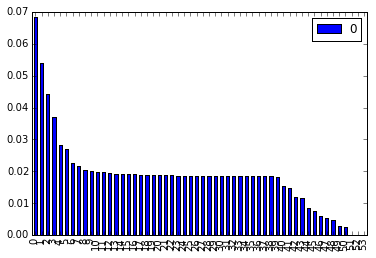

In [7]:
#主成分分析
pca=PCA()
pca.fit(np.r_[Testdata,Traindata,Traindata_test])
pd.DataFrame(pca.explained_variance_ratio_).plot(kind='bar')
n_components=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]
print n_components
print  np.shape(Traindata),np.shape(Testdata),np.shape(Traindata_test)

In [8]:
#降维
pca=PCA(n_components=n_components)
pca.fit(np.r_[Testdata,Traindata,Traindata_test])
Traindata=pca.transform(Traindata)
Traindata_test=pca.transform(Traindata_test)
Testdata=pca.transform(Testdata)
print  np.shape(Traindata),np.shape(Testdata),np.shape(Traindata_test)

(13608L, 48L) (565892L, 48L) (1512L, 48L)


(13608L, 48L) (1512L, 48L)
(13608L, 48L) (565892L, 48L) (1512L, 48L)


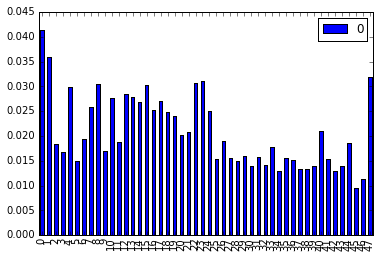

In [9]:
##特征提取
## filter features by forest model
trees = ExtraTreesClassifier(n_estimators=100)
trees.fit(Traindata, Trainlabel)
pd.DataFrame(trees.feature_importances_).plot(kind='bar')
selected_features = np.where(trees.feature_importances_ > 0.005)[0]
Traindata = Traindata[:, selected_features]
Traindata_test = Traindata_test[:, selected_features]
print Traindata.shape, Traindata_test.shape
print  np.shape(Traindata),np.shape(Testdata),np.shape(Traindata_test)

In [17]:
#调用kNN进行预测
from sklearn.neighbors import KNeighborsClassifier
def knnClassify1(Traindata,Trainlabel,Traindata_test,Testdata): 
    knnClf=KNeighborsClassifier(n_neighbors=5)
    knnClf.fit(Traindata,np.ravel(Trainlabel))
    Trainlabel_test_predict=knnClf.predict(Traindata_test)
    Trainlabel_predict=knnClf.predict(Testdata)
    return Trainlabel_test_predict,Trainlabel_predict
Trainlabel_test_predict,Trainlabel_predict = knnClassify1(Traindata,Trainlabel,Traindata_test,Testdata)

In [18]:
#测试结果
def Errortest():
    result1=Trainlabel_test_predict
    
    #将结果与跟给定的knn_benchmark对比,以result1为例
    resultGiven=Trainlabel_test
    m,n=np.shape(Traindata_test)
    different1=0      
    for i in xrange(m):
        if result1[i]!=resultGiven[i]:
            different1+=1
    a=float(different1)/m
    print 'Percentage of difference is %f'%a   
Errortest()

Percentage of difference is 0.146164


In [19]:
#保存数据
Trainlabel_predict_df = pd.DataFrame(dict(Id = np.arange(15121, Trainlabel_predict.shape[0]+15121), Cover_Type=Trainlabel_predict))
Trainlabel_predict_df.to_csv('submission.csv', header = True, index=False)